In [1]:
import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()

# Libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, LayerNormalization, Input
from keras.optimizers import SGD
import math

In [2]:
# Useful Functions
def plot_predictions(test,predicted):
    plt.clf()
    plt.plot(test, color='red',label='Real AMZN Stock Price')
    plt.plot(predicted, color='blue',label='Predicted AMZN Stock Price')
    plt.title('AMZN Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('AMZN Stock Price')
    plt.legend()
    plt.show()
    
def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print(f"The root mean squared error is {rmse}")
    
def plot_loss(history, epochs):
    plt.clf()
    plt.plot(history.history['loss'], color='red', label='Loss')
    plt.title(f'Loss After {epochs} Epochs')
    plt.ylabel('Epoch')
    plt.xlabel('Loss')
    plt.legend()
    plt.show()

In [3]:
# Load Data
dataset = pd.read_csv('USD_PHP Historical Data.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2023-01-11,54.900,54.760,55.035,54.760,0.31K,0.22%
2023-01-10,54.780,54.900,54.925,54.765,0.28K,-0.27%
2023-01-09,54.930,55.250,55.303,54.940,0.31K,-1.05%
2023-01-06,55.512,55.825,55.885,55.522,1.26K,-0.55%
2023-01-05,55.820,55.910,56.035,55.750,0.54K,-0.05%


C:\Users\POLO\AppData\Local\Temp\ipykernel_10112\2588048960.py:4: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_set = dataset['2022':].iloc[:,1:2].values
C:\Users\POLO\AppData\Local\Temp\ipykernel_10112\2588048960.py:9: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  dataset["High"]['2022':].plot(figsize=(16,4), legend=True)


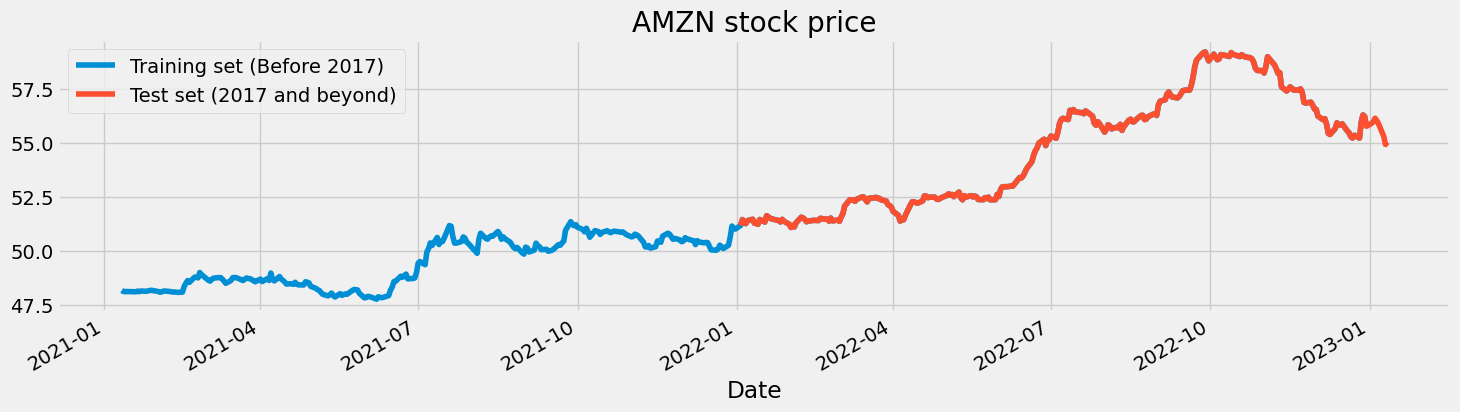

In [4]:
# Split Data
# Checking for missing values
training_set = dataset[:'2022'].iloc[:,1:2].values
test_set = dataset['2022':].iloc[:,1:2].values

# Visualization of data
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2022'].plot(figsize=(16,4), legend=True)
dataset["High"]['2022':].plot(figsize=(16,4), legend=True)

plt.legend(['Training set (Before 2017)', 'Test set (2017 and beyond)'])
plt.title('AMZN stock price')
plt.show()

In [5]:
# Preprocessing of Data
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements
X_train = []
y_train = []

window_size = 16

for i in range(window_size, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-window_size:i,0])
    y_train.append(training_set_scaled[i,0])

X_train = np.array(X_train)
y_train = np.array(y_train)

# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Preparing X_test 
dataset_total = pd.concat((dataset["High"][:'2016'], dataset["High"]['2017':]), axis=0)
inputs = dataset_total[len(dataset_total) - len(test_set) - window_size:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(window_size, len(inputs)):
    X_test.append(inputs[i-window_size:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

C:\Users\POLO\AppData\Local\Temp\ipykernel_10112\1736079850.py:24: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  dataset_total = pd.concat((dataset["High"][:'2016'], dataset["High"]['2017':]), axis=0)


In [6]:
# The LSTM architecture
regressor = Sequential([
    # Input Layer
    Input(shape=(window_size,1)),
    # First LSTM layer
    LSTM(64, return_sequences=True),
    # Second LSTM layer
    Bidirectional(LSTM(64)),
    # Hidden Layer
    Dense(128),
    # The output layer
    Dense(units=1)
])

# Compiling the RNN
regressor.compile(optimizer='adam', loss='mean_squared_error')
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16, 64)            16896     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 99,585
Trainable params: 99,585
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Fitting to training set
epochs = 50
history = regressor.fit(
    X_train, 
    y_train, 
    epochs=epochs, 
    batch_size=32,
#     initial_epoch=10
)

Epoch 1/50
16/16 [==============================] - 8s 25ms/step - loss: 0.0412
Epoch 2/50
16/16 [==============================] - 0s 26ms/step - loss: 0.0054
Epoch 3/50
16/16 [==============================] - 0s 25ms/step - loss: 0.0027
Epoch 4/50
16/16 [==============================] - 0s 25ms/step - loss: 0.0020
Epoch 5/50
16/16 [==============================] - 0s 25ms/step - loss: 0.0019
Epoch 6/50
16/16 [==============================] - 0s 24ms/step - loss: 0.0019
Epoch 7/50
16/16 [==============================] - 0s 24ms/step - loss: 0.0021
Epoch 8/50
16/16 [==============================] - 0s 25ms/step - loss: 0.0018
Epoch 9/50
16/16 [==============================] - 0s 29ms/step - loss: 0.0017
Epoch 10/50
16/16 [==============================] - 0s 30ms/step - loss: 0.0017
Epoch 11/50
16/16 [==============================] - 0s 27ms/step - loss: 0.0018
Epoch 12/50
16/16 [==============================] - 0s 27ms/step - loss: 0.0015
Epoch 13/50
16/16 [==================

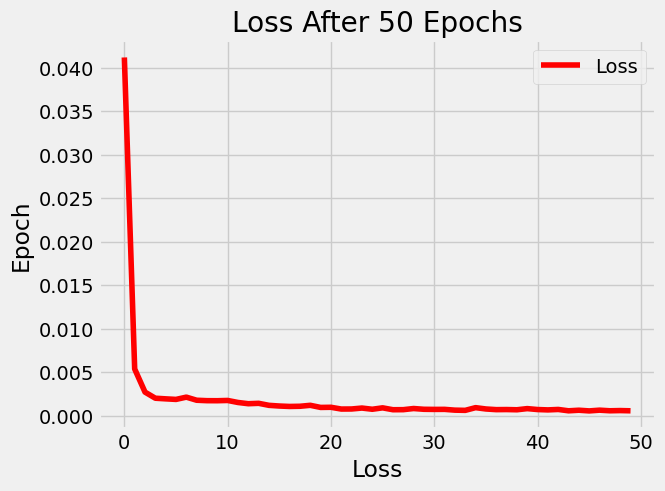

In [8]:
plot_loss(history, epochs)

9/9 [==============================] - 2s 9ms/step


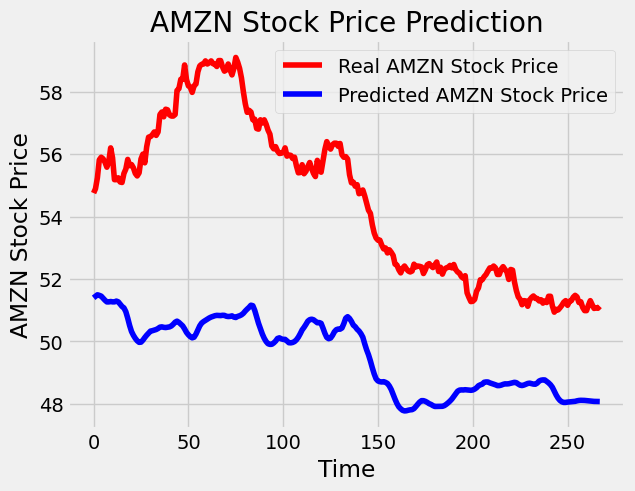

The root mean squared error is 5.250142695585507
Window Size = 16
Epochs = 50


In [9]:
# Predicting the Prices
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
# Visualizing Prediction
plot_predictions(test_set, predicted_stock_price)
# Evaluating our model
return_rmse(test_set, predicted_stock_price)
print(f'Window Size = {window_size}')
print(f'Epochs = {epochs}')